## Merging hourly taxi, weather, and incoming passenger data for 2017

In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
%matplotlib inline

### Reading Aggregated Taxi Data

In [2]:
taxi_hourly_df = pd.read_csv('../clean_data/Aggregated_TaxiData_14-17.csv', index_col=0)

In [3]:
taxi_hourly_df.head()

,num_pickups,num_passengers
tpep_pickup_datetime,,
2014-01-01 00:00:00,107,210.0
2014-01-01 01:00:00,34,45.0
2014-01-01 02:00:00,34,70.0
2014-01-01 03:00:00,12,18.0
2014-01-01 04:00:00,25,37.0


In [4]:
taxi_hourly_df.shape

(26009, 2)

In [5]:
taxi_hourly_df.index = pd.DatetimeIndex(taxi_hourly_df.index)

In [6]:
taxi_hourly_df = taxi_hourly_df.drop([pd.Timestamp('2014-11-02 01:00:00'), pd.Timestamp('2015-11-01 01:00:00'), pd.Timestamp('2017-03-12 02:00:00')])#, pd.Timestamp('2017-03-12 02:00:00')])
taxi_hourly_df.index = taxi_hourly_df.index.tz_localize('America/New_York')

In [7]:
taxi_hourly_df.shape

(26006, 2)

### Checking Missing Hours from Data and adding them to Datetimeindex. Also created a binary column as Indicator

In [8]:
dateindex = pd.date_range(taxi_hourly_df.index.min(), taxi_hourly_df.index.max(), freq="1H")

In [9]:
taxi_hourly_df = taxi_hourly_df.reindex(dateindex)

In [10]:
taxi_hourly_df.head()

,num_pickups,num_passengers
2014-01-01 00:00:00-05:00,107.0,210.0
2014-01-01 01:00:00-05:00,34.0,45.0
2014-01-01 02:00:00-05:00,34.0,70.0
2014-01-01 03:00:00-05:00,12.0,18.0
2014-01-01 04:00:00-05:00,25.0,37.0


In [11]:
taxi_hourly_df["missing_dt"] = np.NaN

In [12]:
taxi_hourly_df.loc[taxi_hourly_df.isnull().all(1) == True, "missing_dt"] = True
taxi_hourly_df.loc[~(taxi_hourly_df.missing_dt == True), "missing_dt"] = False

In [13]:
missing_hours = taxi_hourly_df[(taxi_hourly_df.missing_dt == True) & (taxi_hourly_df.index < "2016-07-01")].index.hour

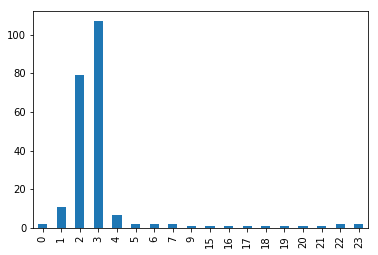

In [14]:
pd.Series(Counter(missing_hours)).plot(kind="bar")

In [15]:
taxi_hourly_df.shape

(30647, 3)

In [16]:
taxi_hourly_df.index.min()

Timestamp('2014-01-01 00:00:00-0500', tz='America/New_York', freq='H')

In [17]:
taxi_hourly_df.index.max()

Timestamp('2017-06-30 23:00:00-0400', tz='America/New_York', freq='H')

In [18]:
len(taxi_hourly_df.index.unique())

30647

In [19]:
taxi_hourly_df["2016-07-01":"2016-12-31"].shape

(4417, 3)

### Weather Data

In [20]:
def clean_weather(path):
    weather_df = pd.read_csv(path)
    weather_df["date"] = pd.DatetimeIndex(pd.to_datetime(weather_df.dt, unit="s")) \
                    .tz_localize('UTC').tz_convert('America/New_York')
    
    weather_df.drop(["dt", "dt_iso", "city_id", "city_name", "lat", "lon", "weather_icon", "grnd_level", \
                 "sea_level", "clouds_all", "weather_id", "rain_1h", "rain_3h", "rain_24h", \
                 "rain_today", "snow_1h", "snow_3h", "snow_24h", "snow_today", "wind_deg", "pressure"], 
                    axis=1, inplace=True)
    return weather_df

In [21]:
weather_df = clean_weather("../clean_data/weather_NY.csv")

In [22]:
weather_df.shape

(49811, 8)

In [23]:
Counter(weather_df["weather_main"].values)

Counter({'Clear': 10342,
         'Clouds': 16999,
         'Drizzle': 1455,
         'Dust': 22,
         'Fog': 1746,
         'Haze': 1188,
         'Mist': 8203,
         'Rain': 8347,
         'Sand': 1,
         'Smoke': 12,
         'Snow': 952,
         'Squall': 6,
         'Thunderstorm': 538})

** Handling Dust, Sand, Smoke and Squall Weather Types **

In [24]:
## set these weather conditions to NaN and ffill them with previous hours data
weather_df.loc[weather_df["weather_main"].isin(["Dust", "Sand", "Smoke", "Squall"]), ["weather_main", "weather_description"]] = np.NaN
weather_df = weather_df.fillna(method="ffill")

In [25]:
weather_df.shape

(49811, 8)

** Combining Weather Types **

In [26]:
Counter(weather_df["weather_main"].values)

Counter({'Clear': 10347,
         'Clouds': 17016,
         'Drizzle': 1455,
         'Fog': 1747,
         'Haze': 1197,
         'Mist': 8207,
         'Rain': 8349,
         'Snow': 952,
         'Thunderstorm': 541})

In [27]:
# Lowercase Weather Types
weather_df["weather_main"] = weather_df.weather_main.str.lower()
weather_df["weather_description"] = weather_df.weather_description.str.lower()

In [28]:
# Handle Drizzle Weather Type
weather_df["weather_main"] = weather_df.weather_main.str.replace("drizzle", "rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("drizzle", "light rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("heavy intensity drizzle", "moderate rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("light intensity drizzle", "light rain")

In [29]:
# Handle Drizzle and Mist Weather Type - Combine to Fog
weather_df["weather_main"] = weather_df.weather_main.str.replace("haze", "fog")
weather_df["weather_description"] = weather_df.weather_description.str.replace("haze", "fog")
weather_df["weather_main"] = weather_df.weather_main.str.replace("mist", "fog")
weather_df["weather_description"] = weather_df.weather_description.str.replace("mist", "fog")

In [30]:
# Handle Rain Weather Type
weather_df["weather_description"] = weather_df.weather_description.str.replace("light intensity light rain", "light rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("light intensity shower rain", "light rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("light intensity light rain", "light rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("heavy intensity light rain", "light rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("shower rain", "light rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("very heavy rain", "heavy intensity rain")

In [31]:
# Handle Snow Weather Type
weather_df["weather_description"] = weather_df.weather_description.str.replace("light rain and snow", "light snow")
weather_df["weather_description"] = weather_df.weather_description.str.replace("rain and snow", "snow")
weather_df["weather_description"] = weather_df.weather_description.str.replace("sleet", "snow")

In [32]:
# Handling Thunderstorm Data Type
weather_df["weather_description"] = weather_df.weather_description.str.replace("proximity thunderstorm with light rain", "proximity thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("proximity thunderstorm with rain", "proximity thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("proximity thunderstorm with light rain", "proximity thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("thunderstorm with heavy rain", "thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("thunderstorm with light light rain", "thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("thunderstorm with light rain", "thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("thunderstorm with rain", "thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("heavy thunderstorm", "thunderstorm")

In [33]:
#weather_df.groupby(["weather_main", "weather_description"]).sum()

In [34]:
# For every hour, if extreme weather type (thunderstorm, snow, rain or fog), return that, else just return the first 
# wether type reported in that hour

def getExtreme_WeatherMain(vals):
    if "thunderstorm" in vals.values:
        return "thunderstorm"
    elif "snow" in vals.values:
        return "snow"
    elif "rain" in vals.values:
        return "rain"
    elif "fog" in vals.values:
        return "fog"
    else:
        return vals.values[0]
    
def getExtreme_WeatherDesc(vals):
    if "thunderstorm" in vals.values:
        return "thunderstorm"
    elif "proximity thunderstorm" in vals.values:
        return "proximity thunderstorm"
    elif "heavy snow" in vals.values:
        return "heavy snow"
    elif "snow" in vals.values:
        return "snow"
    elif "light snow" in vals.values:
        return "light snow"
    elif "freezing rain" in vals.values:
        return "freezing rain"
    elif "heavy intensity rain" in vals.values:
        return "heavy intensity rain"
    elif "moderate rain" in vals.values:
        return "moderate rain"
    elif "light rain" in vals.values:
        return "light rain"
    elif "fog" in vals.values:
        return "fog"
    else:
        return vals.values[0]

In [35]:
# data_1 = {'date' : ['2014-01-01 00:00:00-05:00', '2014-01-01 00:00:00-05:00', '2014-01-01 00:00:00-05:00'],
#           'weather_main' : ["fog", "clouds", "snow"],
#           'weather_description' : ["fog", "broken clouds", "light snow"]}
# df_1 = pd.DataFrame(data_1)
# df_1
# df_1.groupby("date").agg({"weather_main" : lambda x: getExtreme_WeatherMain(x),
#                           "weather_description" : lambda x : getExtreme_WeatherDesc(x)})

In [36]:
weather_df = weather_df.groupby("date").agg({"temp":"mean", "temp_min":"mean", "temp_max":"mean", "humidity": "mean",
                                "wind_speed":"mean", "weather_main" : lambda x: getExtreme_WeatherMain(x),
                                "weather_description" : lambda x : getExtreme_WeatherDesc(x) })

In [37]:
#weather_df.groupby(["weather_main", "weather_description"]).sum()

In [38]:
weather_df = weather_df.reindex(taxi_hourly_df.index)

In [39]:
## Filled in missing hours with the data available for previous hours
weather_df = weather_df.fillna(method = "ffill")

In [40]:
#weather_df[weather_df.weather_main.isnull()]

### Merge Taxi and Weather Data

In [41]:
taxi_weather_df = pd.concat([taxi_hourly_df, weather_df], axis=1)

In [42]:
taxi_weather_df.head()

,num_pickups,num_passengers,missing_dt,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description
2014-01-01 00:00:00-05:00,107.0,210.0,False,269.27,267.59,270.93,80.0,3.0,clear,sky is clear
2014-01-01 01:00:00-05:00,34.0,45.0,False,268.90,267.04,270.93,80.0,2.0,clear,sky is clear
2014-01-01 02:00:00-05:00,34.0,70.0,False,268.48,266.48,270.37,57.0,3.0,clear,sky is clear
2014-01-01 03:00:00-05:00,12.0,18.0,False,268.33,265.93,270.37,80.0,3.0,clear,sky is clear
2014-01-01 04:00:00-05:00,25.0,37.0,False,268.10,265.37,270.37,80.0,3.0,clear,sky is clear


In [43]:
taxi_weather_df.shape

(30647, 10)

### Passenger seat data

In [44]:
def clean_seats(path):
    seats_per_hour = pd.read_csv(path)
    seats_per_hour.columns = ['Time', 'Passengers']
    seats_per_hour["Time"] = pd.DatetimeIndex(seats_per_hour.Time)
    seats_per_hour.set_index("Time", inplace = True)

    #To get rid of errors surrounding daylight savings time. All of taxi pickups and passenger counts are NaNs for these times
    seats_per_hour = seats_per_hour.drop([pd.Timestamp('2014-03-09 02:00:00'), pd.Timestamp('2014-11-02 01:00:00'), pd.Timestamp('2015-03-08 02:00:00'), pd.Timestamp('2015-11-01 01:00:00'), pd.Timestamp('2016-03-13 02:00:00'), pd.Timestamp('2016-11-06 01:00:00'), pd.Timestamp('2017-03-12 02:00:00')])
    seats_per_hour.index = seats_per_hour.index.tz_localize('America/New_York')
    return seats_per_hour

In [45]:
seats_per_hour = clean_seats('../clean_data/passengers_per_hour_since_2014.csv')

In [46]:
seats_per_hour = seats_per_hour.reindex(taxi_weather_df.index)

### Merging all dataframes

In [47]:
merged_df = pd.concat([taxi_weather_df, seats_per_hour], axis=1)

In [48]:
merged_df.shape

(30647, 11)

In [49]:
merged_df.head()

,num_pickups,num_passengers,missing_dt,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description,Passengers
2014-01-01 00:00:00-05:00,107.0,210.0,False,269.27,267.59,270.93,80.0,3.0,clear,sky is clear,108.0
2014-01-01 01:00:00-05:00,34.0,45.0,False,268.90,267.04,270.93,80.0,2.0,clear,sky is clear,0.0
2014-01-01 02:00:00-05:00,34.0,70.0,False,268.48,266.48,270.37,57.0,3.0,clear,sky is clear,0.0
2014-01-01 03:00:00-05:00,12.0,18.0,False,268.33,265.93,270.37,80.0,3.0,clear,sky is clear,0.0
2014-01-01 04:00:00-05:00,25.0,37.0,False,268.10,265.37,270.37,80.0,3.0,clear,sky is clear,0.0


In [50]:
merged_df['Month'] = merged_df.index.month

In [51]:
merged_df['Hour'] = merged_df.index.hour

In [52]:
merged_df['Day'] = merged_df.index.dayofweek

In [53]:
merged_df.head()

,num_pickups,num_passengers,missing_dt,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description,Passengers,Month,Hour,Day
2014-01-01 00:00:00-05:00,107.0,210.0,False,269.27,267.59,270.93,80.0,3.0,clear,sky is clear,108.0,1,0,2
2014-01-01 01:00:00-05:00,34.0,45.0,False,268.90,267.04,270.93,80.0,2.0,clear,sky is clear,0.0,1,1,2
2014-01-01 02:00:00-05:00,34.0,70.0,False,268.48,266.48,270.37,57.0,3.0,clear,sky is clear,0.0,1,2,2
2014-01-01 03:00:00-05:00,12.0,18.0,False,268.33,265.93,270.37,80.0,3.0,clear,sky is clear,0.0,1,3,2
2014-01-01 04:00:00-05:00,25.0,37.0,False,268.10,265.37,270.37,80.0,3.0,clear,sky is clear,0.0,1,4,2


### Adding Federal Calendar Holidays

In [54]:
dr = pd.to_datetime(pd.to_datetime(merged_df.index.date))

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

merged_df['holiday'] = dr.isin(holidays)

In [55]:
merged_df.to_csv("../clean_data/FinalData_for_Models.csv")

---